In [1]:
import pandas as pd
import numpy as np
import json
import warnings
from time import sleep
from tqdm import tqdm, trange
from pymongo import MongoClient, errors
from lightweight_charts import JupyterChart
from icecream import ic

warnings.filterwarnings('ignore')


In [2]:
host = 'localhost'
port = 27017
db_name = 'oquant_runtime'
coll_name = '1234:group_prices'
strategy_id = '1'

client = MongoClient(host, port, serverSelectionTimeoutMS=5000)
db = client[db_name]
coll = db[coll_name]


In [3]:
def to_straddle_group(df):    
    def split_series(s, n):
        # 将Series转换为numpy数组
        arr = s.to_numpy()
        
        # 计算连续NaN的个数
        mask = np.concatenate(([False], np.isnan(arr), [False]))
        idx = np.flatnonzero(mask[1:] != mask[:-1])
        counts = idx[1::2] - idx[::2]
        
        # 找到连续NaN个数超过n的位置
        split_points = idx[1::2][counts >= n]
        
        # 分段并删除NaN
        segments = np.split(s, split_points)
        segments = [segment.dropna() for segment in segments]
        
        # 获取每个分段的起始和结束位置
        positions = [(segment.index[0], segment.index[-1]) for segment in segments if len(segment) > 0]
        
        return positions

    def get_origin_seqments(df):
        # 分段并删除连续NaN个数超过2的部分
        undl_symbol = None
        positions = []
        symbols = []
        for i in range(1, len(df.columns)):
            symbol = df.columns[i]
            pos = split_series(df.iloc[:, i], 50)
            if len(pos) == 1 and pos[0][1] - pos[0][0] + 5 >= len(df) and undl_symbol is None:
                undl_symbol = symbol
            else:
                [positions.append(p) for p in pos]
                for i in range(len(pos)):
                    symbols.append(symbol)
        
        return {
            'underlying_symbol': undl_symbol,
            'positions': positions,
            'symbols': symbols
        }
        
    def decompose_tuples(lst):
        result = {"old": [], "new": []}
        for i in range(len(lst)):
            overlaps = [j for j in range(len(lst)) if lst[j][0] >= lst[i][0] and lst[j][1] <= lst[i][1] and j != i]
            if len(overlaps) >= 2:
                result["old"].append(lst[i])
                result["new"].extend([lst[j] for j in overlaps])
        return result
        
    def get_new_seqments_info(df):
        info = get_origin_seqments(df)
        undl_symbol = info['underlying_symbol']
        positions = info['positions']
        symbols = info['symbols']

        changed_positions = decompose_tuples(positions)
        indexes = []
        for i in range(len(changed_positions['old'])):
            idx = positions.index(changed_positions['old'][i])
            indexes.append(idx)
            positions.extend(changed_positions['new'])
            symbols.extend([symbols[idx]] * len(changed_positions['new'][i]))
        positions = [pos for idx, pos in enumerate(positions) if idx not in indexes]
        symbols = [sym for idx, sym in enumerate(symbols) if idx not in indexes]
        
        return {
            'underlying_symbol': undl_symbol,
            'positions': positions,
            'symbols': symbols
        }
        
    def pair_tuples(tuples):
        # 按照范围的开始进行排序
        tuples = tuples.copy()
        tuples.sort(key=lambda x: x[0])
        
        pairs = []
        while tuples:
            # 选择范围最大的元组
            max_range_tuple = max(tuples, key=lambda x: x[1])
            tuples.remove(max_range_tuple)
            
            # 寻找可以被当前元组包含的元组
            for i in range(len(tuples)):
                if tuples[i][0] >= max_range_tuple[0] and tuples[i][1] <= max_range_tuple[1]:
                    pairs.append((max_range_tuple, tuples[i]))
                    tuples.pop(i)
                    break
        
        return pairs

    def create_group(df):
        info = get_new_seqments_info(df)
        undl_symbol = info['underlying_symbol']
        positions = info['positions']
        symbols = info['symbols']
        positions = [(b[0], b[1], a) for a, b in zip(symbols, positions)]
        pairs = pair_tuples(positions)
        
        df[undl_symbol].ffill(inplace=True)
        work_dfs = []
        pairs.sort(key=lambda x: x[0][0])
        for pair in pairs:
            start_pos = min(pair[0][0], pair[1][0])
            end_pos = max(pair[0][1], pair[1][1])
            data = df.loc[start_pos:end_pos, ['datetime', undl_symbol, pair[0][2], pair[1][2]]]
            # ic(pair)
            data['TotalPrice'] = data[pair[0][2]] + data[pair[1][2]]
            data.bfill(inplace=True)
            data.set_index('datetime', drop=True, inplace=True)
            
            data['Rise'] = data['TotalPrice'].shift(1) - data['TotalPrice']
            
            work_dfs.append(data)
        
        return work_dfs
    
    return create_group(df)

def compute_profit(all_groups):
    all_profit = []
    all_underlying = []
    straddle_groups = []
    for i, group in enumerate(tqdm(all_groups, desc='正在计算收益')):    
        prices = group['prices']
        prices = json.loads(prices)
        df = pd.DataFrame.from_dict(prices, orient='index')
        df = df.reset_index().rename(columns={'index': 'datetime'})
        group = to_straddle_group(df)
        rise = [g.loc[~pd.isnull(g['Rise']), 'Rise'] for g in group.copy()]
        all_profit.append(pd.concat(rise).cumsum())
        all_underlying.append(df.iloc[:, :2])
        straddle_groups.append(group)

        
    total_profits = pd.concat(all_profit, axis=1)
    total_profits.ffill(inplace=True)    
    total_profits.fillna(0, inplace=True)
    total = total_profits.sum(axis=1)
    total.index = pd.to_datetime(total.index)
    
    underlying = pd.concat(all_underlying).drop_duplicates(subset=['datetime'])
    underlying.sort_values('datetime', inplace=True)
    underlying['datetime'] = pd.to_datetime(underlying['datetime'])
    underlying.set_index('datetime', drop=True, inplace=True)
    
    
    return underlying, total, total_profits, straddle_groups

def get_chart_data(underlying, total_profits, timeframe='D'):
    df1 = underlying.resample(timeframe).agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last'
            })
    df1.dropna(how='all', inplace=True)
    
    df2 = total_profits.resample(timeframe).agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last'
            })
    df2.dropna(how='all', inplace=True)
    
    return df1, df2



In [4]:
all_groups = coll.find({'strategy_id': strategy_id})
underlying, total, total_profits, straddle_groups = compute_profit(all_groups)


正在计算收益: 752it [00:31, 23.54it/s]


In [39]:
def historical_volatility(prices, window=252):
    returns = prices.pct_change().dropna()  # 计算收益率
    volatility = returns.rolling(window=window, min_periods=1).std() * np.sqrt(window)  # 使用滚动窗口计算波动率，并年化
    return volatility

hvi = historical_volatility(underlying)
hvi.rename(columns={'510050.SH':'open'},inplace=True)
hvi['high'] = hvi['open']
hvi['low'] = hvi['open']
hvi['close'] = hvi['open']
hvi = hvi.resample('1w').agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last'
        })
hvi.dropna(how='all', inplace=True)

<Axes: xlabel='datetime'>

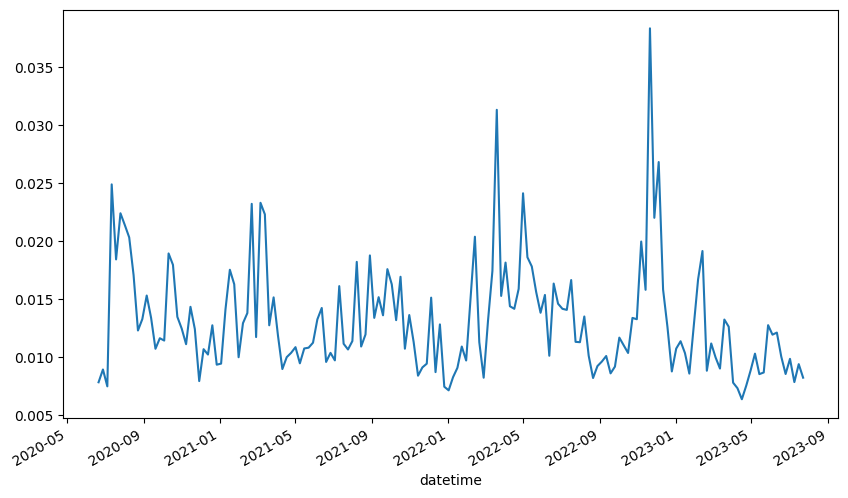

In [48]:
hvi['open'].plot(figsize=(10, 6))

In [57]:
hvi = historical_volatility(underlying)
# hvi.loc[hvi['510050.SH'] >= 0.03]

In [ ]:
# 绘制整体收益
total.plot()

In [35]:
undl_name = underlying.columns[0]
undl_data = underlying[undl_name]
undl_bars, profits = get_chart_data(undl_data, total, timeframe='1w')

chart_1 = JupyterChart()
chart_1.set(profits)
chart_1.load()

chart_2 = JupyterChart()
chart_2.set(undl_bars)
chart_2.load()

In [ ]:
def get_profit(total_profits, n):
    def remove_head_tail_continuous_n(series):
        data = total_profits.iloc[:, n].copy()
        diff = data.loc[data!=data.shift()]
        start = data.index[0]
        end = data.index[-1]
        if len(diff) > 0:
            start = diff.index[1]
            end = diff.index[-1]
        return series[start: end]

    return remove_head_tail_continuous_n(total_profits.iloc[:, n])

In [ ]:
# 到出到通达信格式
def to_tdx(total_profits):
    for i in trange(len(total_profits.columns)):
        profit = get_profit(total_profits, i)
        data = pd.DataFrame(profit)
        data['Rise'] = (data['Rise'].round(4) + 1) 
        data.rename(columns={'Rise': 'Open'}, inplace=True)
        data.reset_index(inplace=True)
        data['date'] = pd.date_range(start=data.iloc[0]['datetime'][:10], periods=len(data))
        data['High'] = data['Open']
        data['Low'] = data['Open']
        data['Close'] = data['Open']
        data['volume'] = 1
        data['amount'] = 1
        data = data[['date', 'Open', 'High', 'Low', 'Close', 'volume', 'amount']]
        data.to_csv(f'd:\\temp\\oquant\\{i}.txt', sep=',', header=False, index=False)

to_tdx(total_profits)

In [ ]:
data

In [ ]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

# 定义计算MACD指标的函数
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['ShortEMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['Histogram'] = data['MACD'] - data['Signal Line']
    return data

profit = get_profit(total_profits, 100)
data = pd.DataFrame(profit)
data['Rise'] = 1 + data['Rise']
data.rename(columns={'Rise': 'Open'}, inplace=True)
data['High'] = data['Open']
data['Low'] = data['Open']
data['Close'] = data['Open']
data.reset_index(inplace=True)
data.rename(columns={'datetime': 'Date'}, inplace=True)
# data.index = pd.to_datetime(data.index)

df = calculate_macd(data)

# 创建数据源
source = ColumnDataSource(df)

In [ ]:
# 创建绘图对象
p = figure(x_axis_type='datetime', title='MACD Indicator', height=300, width=800, y_range=(min(df['MACD'])*1.1, max(df['MACD']) * 1.1))

# 绘制MACD线
p.line(x='Date', y='MACD', source=source, legend_label='MACD', color='blue')

# 绘制MACD信号线
p.line(x='Date', y='Signal Line', source=source, legend_label='Signal Line', color='red')

# 绘制MACD柱状图
p.vbar(x='Date', top='Histogram', width=0.9, source=source, legend_label='Histogram', 
       fill_color='green', line_color='black')

# 添加悬停工具
hover = HoverTool()
hover.tooltips = [("Date", "@Date{%F}"), ("MACD", "@MACD"), ("Signal Line", "@{Signal Line}"), ("Histogram", "@Histogram")]
hover.formatters = {'@Date': 'datetime'}
p.add_tools(hover)

# 设置图例位置
p.legend.location = 'top_left'

# 在Jupyter Notebook中显示图表
output_notebook()
show(p)

In [ ]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

# 定义计算MACD指标的函数
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['ShortEMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['Histogram'] = data['MACD'] - data['Signal Line']
    return data

# 示例数据，假设已经有股票价格数据
data = {
    'Date': pd.date_range(start='2022-01-01', periods=100),
    'Close': [100 + 2 * i for i in range(100)]  # 假设股票价格
}

# 转换为DataFrame
df = pd.DataFrame(data)

# 计算MACD指标
df = calculate_macd(df)

# 创建数据源
source = ColumnDataSource(df)

# 创建绘图对象
p = figure(x_axis_type='datetime', title='MACD Indicator', height=300, width=800)

# 绘制MACD线
p.line(x='Date', y='MACD', source=source, legend_label='MACD', color='blue')

# 绘制MACD信号线
p.line(x='Date', y='Signal Line', source=source, legend_label='Signal Line', color='red')

# 绘制MACD柱状图
p.vbar(x='Date', top='Histogram', width=0.9, source=source, legend_label='Histogram', 
       fill_color='green', line_color='black')

# 添加悬停工具
hover = HoverTool()
hover.tooltips = [("Date", "@Date{%F}"), ("MACD", "@MACD"), ("Signal Line", "@{Signal Line}"), ("Histogram", "@Histogram")]
hover.formatters = {'@Date': 'datetime'}
p.add_tools(hover)

# 设置图例位置
p.legend.location = 'top_left'

# 在Jupyter Notebook中显示图表
output_notebook()
show(p)


In [ ]:
data

In [ ]:
# 注意： 轻易不要运行，太耗时了！！！
# 绘制每个交易单元的收益
for i in range(len(total_profits.columns)):
    profit = total_profits.iloc[:i]
    profit.plot()